In [1]:
import numpy as np
import torch
from tqdm import tqdm
from time import time

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

import reservoir
import computekernel
from reckernel import RecKernel
from kuramoto import KS
%load_ext autoreload
%autoreload 2
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
L    = 6
N    = 100
dt   = 0.25
ninittransients = 1000
tend = 5000 + ninittransients*dt  #50000
dns  = KS(L=L, N=N, dt=dt, tend=tend)

N_data_train = 10000
N_data_test = 10000

dns.simulate()
u = dns.uu[ninittransients:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_data_train, N_data_train+N_data_test], axis=0)

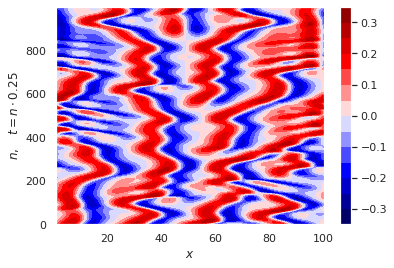

In [3]:
N_plot = 1000
u_plot = u[:N_plot,:]
N_plot = np.shape(u_plot)[0]
# Plotting the contour plot
fig = plt.subplots()
# t, s = np.meshgrid(np.arange(N_plot)*dt, np.array(range(N))+1)
n, s = np.meshgrid(np.arange(N_plot), np.array(range(N))+1)
plt.contourf(s, n, np.transpose(u_plot), 15, cmap=plt.get_cmap("seismic"))
plt.colorbar()
plt.xlabel(r"$x$")
plt.ylabel(r"$n, \quad t=n \cdot {:}$".format(dt));

#     plt.savefig(base_path + "/Figures/Plot_U_first_N{:d}.png".format(N_plot), bbox_inches="tight")
#     plt.close()

In [4]:
def gaussian_data(n_input, input_len_max, input_dim, fix_seed=False):
    if fix_seed == True:
        torch.manual_seed(42)
    return torch.randn(n_input, input_len_max, input_dim).to(device) / np.sqrt(input_dim)

In [7]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

# pred_horizon_range = 100
# out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
# out_test = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
# for pred_horizon in range(1, pred_horizon_range+1):
#     out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)
#     out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)
pred_horizon = 10
out_train = torch.roll(u_train_t, -pred_horizon, dims=0)
out_test = torch.roll(u_test_t, -pred_horizon, dims=0)

n_curves = 10
n_res_range = np.logspace(2, 4, num=n_curves, dtype=int)
input_scale = 0.1
res_scale = 0.7

n_p = len(n_res_range)
init_time = np.zeros((n_p,1))
forward_time = np.zeros((n_p,1))
train_time = np.zeros((n_p,1))
pred_time = np.zeros((n_p,1))

# mse = torch.zeros(n_curves, pred_horizon_range)

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    
    start = time()
    torch.cuda.synchronize()
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf')
    torch.cuda.synchronize()
    init_time[i] = time() - start
    start = time()
    torch.cuda.synchronize()
    X = model.forward(u_train_t, initial_state=initial_state).to(device)
    torch.cuda.synchronize()
    forward_time[i] = time() - start

    start = time()
    torch.cuda.synchronize()
    output_w = model.train(X, out_train)
    torch.cuda.synchronize()
    train_time[i] = time() - start
#     pred_output = X @ output_w

    start = time()
    torch.cuda.synchronize()
    Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
    pred_output_test = Xtest @ output_w
    torch.cuda.synchronize()
    pred_time[i] = time() - start

#     for pred_horizon in range(1, pred_horizon_range+1):
#         mse[i, pred_horizon-1] = torch.mean(
#             (pred_output_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] 
#             - out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim])**2)

10it [01:26,  8.66s/it]


In [8]:
times = np.concatenate((init_time, forward_time, train_time, pred_time), axis=1)
np.save('out/200522_time_rc_kslen1e4_long', times)

In [9]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

# pred_horizon_range = 100
# out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
# out_test = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
# for pred_horizon in range(1, pred_horizon_range+1):
#     out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)
#     out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)
pred_horizon = 10
out_train = torch.roll(u_train_t, -pred_horizon, dims=0)
out_test = torch.roll(u_test_t, -pred_horizon, dims=0)

n_curves = 3
first_pow = 8
last_pow = 15  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
# n_res_range = np.logspace(2, 4, num=n_curves, dtype=int)
input_scale = 0.1
res_scale = 0.7

n_p = len(n_res_range)
init_time = np.zeros((n_p,1))
forward_time = np.zeros((n_p,1))
train_time = np.zeros((n_p,1))
pred_time = np.zeros((n_p,1))

# mse = torch.zeros(n_curves, pred_horizon_range)

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    
    start = time()
    torch.cuda.synchronize()
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', random_projection='structured')
    torch.cuda.synchronize()
    init_time[i] = time() - start
    start = time()
    torch.cuda.synchronize()
    X = model.forward(u_train_t, initial_state=initial_state).to(device)
    torch.cuda.synchronize()
    forward_time[i] = time() - start

    start = time()
    torch.cuda.synchronize()
    output_w = model.train(X, out_train)
    torch.cuda.synchronize()
    train_time[i] = time() - start
#     pred_output = X @ output_w

    Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
    start = time()
    torch.cuda.synchronize()
    pred_output_test = Xtest @ output_w
    torch.cuda.synchronize()
    pred_time[i] = time() - start

#     for pred_horizon in range(1, pred_horizon_range+1):
#         mse[i, pred_horizon-1] = torch.mean(
#             (pred_output_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] 
#             - out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim])**2)

7it [00:30,  4.33s/it]


RuntimeError: CUDA out of memory. Tried to allocate 3.98 GiB (GPU 0; 10.76 GiB total capacity; 5.84 GiB already allocated; 3.65 GiB free; 6.26 GiB reserved in total by PyTorch)

In [ ]:
times = np.concatenate((init_time, forward_time, train_time, pred_time), axis=1)
np.save('out/200522_time_src_kslen1e4', times)